This notebook implements a very simple sequential network with pytorch. The dataset used is very small, and only used for some preliminary trials. The dataset is composed of three T1 images (class 0) and three FA images (class 1). The aim of this simple network is to classify images into the two classes. The training is done using a GPU and, in this example, only the central 10 axial slices are used.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms

torch.set_printoptions(edgeitems=2)
torch.manual_seed(0)

In [2]:
#mount the drive folder
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/work/my_tests

Mounted at /content/drive
/content/drive/My Drive/work/my_tests


In [3]:
#load the dataset as an instance of the class customDataset
from customDataset import HCPanatDataset

img_dir = 'HCP-anat-data/images/'
dataset = HCPanatDataset(csv_file='HCP-anat-data/annotations.csv', root_dir=img_dir)

Training on device cuda.


In [4]:
#transform in torch tensor with transforms.ToTensor()
dataset_t = HCPanatDataset(csv_file='HCP-anat-data/annotations.csv', root_dir=img_dir, transform=transforms.ToTensor())

In [5]:
#compute the mean and std of the data
t1, _ = dataset[0]
max_dim = len(t1.shape) #concatenating dimension
imgs = torch.stack([img_t for img_t, _ in dataset_t], dim=max_dim)
#mean = torch.mean(imgs)
#std = torch.std(imgs)

In [6]:
#select some axial slices
print(imgs.shape) #z,y,y,n_sub
n_axial = 10
z_min = np.int(imgs.shape[0]/2) - np.int(n_axial/2)
z_max = np.int(imgs.shape[0]/2) + np.int(n_axial/2)
z_min, z_max

torch.Size([145, 145, 174, 6])


(67, 77)

In [7]:
#crop dataset
n_crop = 20
imgs = imgs[z_min:z_max, n_crop:-n_crop, n_crop:-n_crop, :]
print(imgs.shape) #z,y,y,n_sub

torch.Size([10, 105, 134, 6])


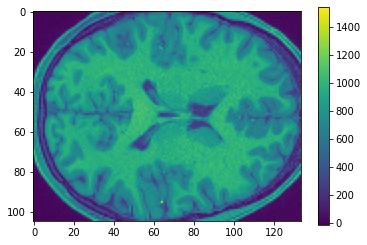

In [8]:
#visualize an example of T1 cropped
t1 = imgs[0]
im=plt.imshow(t1[:,:,0])
plt.colorbar(im)

In [9]:
mean = torch.mean(imgs)
std = torch.std(imgs)
mean, std

(tensor(334.1097), tensor(395.9514))

In [10]:
#normalize the data
transformed_dataset = HCPanatDataset(
    csv_file='HCP-anat-data/annotations.csv', 
    root_dir=img_dir, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean,std)]))

In [11]:
#split the dataset into training and test sets with torch.utils.data.random_split
from torch.utils.data import random_split
N = len(transformed_dataset)
perc_train = 0.8
train_set, test_set = random_split(transformed_dataset, [int(perc_train*N), N-int(perc_train*N)]) 
print("Total number of images: %i" %N)
print("Number of training images: %i" %(perc_train*N))
print("Number of test images: %i" %(N-int(perc_train*N)))

Total number of images: 6
Number of training images: 4
Number of test images: 2


In [12]:
#assuming that we are on a CUDA machine, this should print a CUDA device:
device = (torch.device('cuda') if torch.cuda.is_available() 
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [13]:
#define the sequence of models with nn.Sequential()
import torch.nn as nn
n_in = imgs.shape[0] * imgs.shape[1] * imgs.shape[2] #number of input features
n_out = 2 #number of output features, i.e. number of classes
seq_model = nn.Sequential(
            nn.Linear(n_in, 128), 
            nn.Tanh(),
            nn.Linear(128, n_out))
seq_model = seq_model.to(device=device)
print("The number of input feature is: %i" %n_in)

The number of input feature is: 140700


In [14]:
#define the optimizer (SGD) and the loss (NLL)
import torch.optim as optim
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
loss = nn.NLLLoss()

In [15]:
#define hyperparameters
n_epochs = 20
batch_size = 1

In [16]:
#split the datasets into batches
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [17]:
#define the training loop
def training_loop_val(model, train_loader, test_loader, criterion, optimizer, n_epochs):
  "Training loop with training and validation loss"
  loss_vector = np.zeros(n_epochs)
  loss_val_vector = np.zeros(n_epochs)
  
  for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        imgs = imgs[:,z_min:z_max, n_crop:-n_crop, n_crop:-n_crop]
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = criterion(outputs, labels)
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for imgs_test, labels_test in test_loader: 
        imgs_test = imgs_test[:,z_min:z_max, n_crop:-n_crop, n_crop:-n_crop]
        imgs_test = imgs_test.to(device=device)
        labels_test = labels_test.to(device=device)
        outputs_test = model(imgs_test.view(imgs_test.shape[0], -1))
        loss_test = criterion(outputs_test, labels_test)

    loss_vector[epoch] = float(loss)
    loss_val_vector[epoch] = float(loss_test)    
    print("Epoch: %d, Training Loss: %f, Validation Loss: %f" %(epoch, float(loss), float(loss_test)))    

  return loss_vector, loss_val_vector

In [18]:
for imgs, labels in train_loader:
    print(imgs.shape)
    imgs = imgs[:,z_min:z_max, n_crop:-n_crop, n_crop:-n_crop]
    print(imgs.shape)

torch.Size([1, 145, 145, 174])
torch.Size([1, 10, 105, 134])
torch.Size([1, 145, 145, 174])
torch.Size([1, 10, 105, 134])
torch.Size([1, 145, 145, 174])
torch.Size([1, 10, 105, 134])
torch.Size([1, 145, 145, 174])
torch.Size([1, 10, 105, 134])


In [19]:
#training and showing also validation loss
import time
t0 = time.time()
loss_vector, loss_val_vector = training_loop_val(
    model = seq_model,
    train_loader = train_loader,
    test_loader = test_loader,
    criterion = loss,
    optimizer = optimizer,
    n_epochs = n_epochs)
print("Training time = %f seconds" %(time.time()-t0))

Epoch: 0, Training Loss: -0.185581, Validation Loss: -0.828357
Epoch: 1, Training Loss: -6.023130, Validation Loss: -1.489363
Epoch: 2, Training Loss: -6.133058, Validation Loss: -2.155596
Epoch: 3, Training Loss: -6.282314, Validation Loss: -2.772813
Epoch: 4, Training Loss: -2.956042, Validation Loss: -3.056298
Epoch: 5, Training Loss: -3.215949, Validation Loss: -3.302157
Epoch: 6, Training Loss: -7.152423, Validation Loss: -3.503626
Epoch: 7, Training Loss: -3.733566, Validation Loss: -7.543720
Epoch: 8, Training Loss: -3.990111, Validation Loss: -4.049729
Epoch: 9, Training Loss: -4.248334, Validation Loss: -8.064882
Epoch: 10, Training Loss: -4.512870, Validation Loss: -8.321591
Epoch: 11, Training Loss: -8.444700, Validation Loss: -4.812172
Epoch: 12, Training Loss: -5.049004, Validation Loss: -8.744152
Epoch: 13, Training Loss: -5.415105, Validation Loss: -9.077962
Epoch: 14, Training Loss: -9.209587, Validation Loss: -9.348403
Epoch: 15, Training Loss: -9.476985, Validation Lo

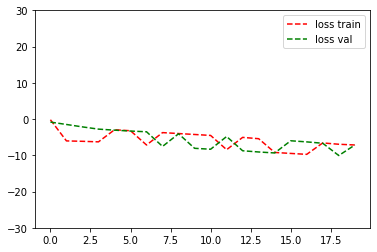

In [20]:
#plot training and validation loss
x_axis = np.arange(n_epochs)
plt.plot(x_axis, loss_vector, 'r--', label='loss train')
plt.plot(x_axis, loss_val_vector, 'g--', label='loss val')
plt.ylim(-30, 30)
plt.legend()

In [21]:
#check accuracy
def check_accuracy(loader, model):

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for imgs, labels in loader:
      imgs = imgs[:,z_min:z_max, n_crop:-n_crop, n_crop:-n_crop]
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      outputs = model(imgs.view(imgs.shape[0], -1))
      _, predicted = torch.max(outputs, dim=1)
      total += labels.shape[0]
      correct += int((predicted == labels).sum())
        
  print("Accuracy: %f" % (correct / total))

In [22]:
#compute accuracy in training
check_accuracy(train_loader, seq_model)

Accuracy: 1.000000


In [23]:
#compute accuracy in test
check_accuracy(test_loader, seq_model)

Accuracy: 1.000000


In [24]:
#free some RAM
del seq_model
del dataset, dataset_t, transformed_dataset
del train_set, test_set, imgs

In [25]:
#increase the number of layers and change the loss to CrossEntropy
seq_model_large = nn.Sequential(
            nn.Linear(n_in, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, n_out))
seq_model_large = seq_model_large.to(device=device)
optimizer = optim.SGD(seq_model_large.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [26]:
#training and showing also validation loss
import time
t0 = time.time()
loss_vector, loss_val_vector = training_loop_val(
    model = seq_model_large,
    train_loader = train_loader,
    test_loader = test_loader,
    criterion = loss_fn,
    optimizer = optimizer,
    n_epochs = n_epochs)
print("Training time = %f seconds" %(time.time()-t0))

Epoch: 0, Training Loss: 0.062759, Validation Loss: 0.060741
Epoch: 1, Training Loss: 0.059508, Validation Loss: 0.056227
Epoch: 2, Training Loss: 0.054141, Validation Loss: 0.054868
Epoch: 3, Training Loss: 0.053686, Validation Loss: 0.053085
Epoch: 4, Training Loss: 0.051939, Validation Loss: 0.051643
Epoch: 5, Training Loss: 0.050236, Validation Loss: 0.048202
Epoch: 6, Training Loss: 0.049148, Validation Loss: 0.047047
Epoch: 7, Training Loss: 0.046323, Validation Loss: 0.048464
Epoch: 8, Training Loss: 0.045396, Validation Loss: 0.045134
Epoch: 9, Training Loss: 0.046643, Validation Loss: 0.044322
Epoch: 10, Training Loss: 0.043791, Validation Loss: 0.046173
Epoch: 11, Training Loss: 0.043086, Validation Loss: 0.042885
Epoch: 12, Training Loss: 0.042426, Validation Loss: 0.042239
Epoch: 13, Training Loss: 0.041804, Validation Loss: 0.041631
Epoch: 14, Training Loss: 0.041218, Validation Loss: 0.043776
Epoch: 15, Training Loss: 0.043064, Validation Loss: 0.040507
Epoch: 16, Trainin

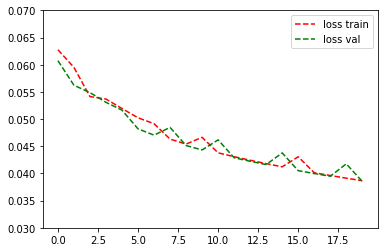

In [27]:
#plot training and validation loss
x_axis = np.arange(n_epochs)
plt.plot(x_axis, loss_vector, 'r--', label='loss train')
plt.plot(x_axis, loss_val_vector, 'g--', label='loss val')
plt.ylim(0.03, 0.07)
plt.legend()

In [28]:
#compute accuracy in training
check_accuracy(train_loader, seq_model_large)

Accuracy: 1.000000


In [29]:
#compute accuracy in test
check_accuracy(test_loader, seq_model_large)

Accuracy: 1.000000


In [30]:
numel_list = [p.numel()
              for p in seq_model_large.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list              

(18018114, [18009600, 128, 8192, 64, 128, 2])

w.r.t. the previous example that uses the entire 3D volumes, here we have 18M parameters instead of 468M parameters!